In [1]:
import matplotlib
# %matplotlib inline
# print("BACKEND: ", matplotlib.get_backend())
# if matplotlib.get_backend() != "macosx":
#   print("Changing backend to macosx")
#   matplotlib.use('macosx')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.visualize import view

from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

/home/ntt203/.conda/envs/raffle_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-28 14:36:26,676	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
from agox.models.descriptors.fingerprint import Fingerprint
from agox.models.descriptors import Voronoi
import numpy as np

template = Atoms("", cell=np.eye(3) * 3.567, pbc=True)
diamond = bulk("C", "diamond", a=3.567)  # Lattice constant for diamond cubic carbon
confinement_cell = template.cell.copy()
confinement_corner = np.array([0, 0, 0])
environment = Environment(
    template=template,
    symbols="C8",
    confinement_cell=confinement_cell,
    confinement_corner=confinement_corner,
    box_constraint_pbc=[True, True, True],  # Confinement is periodic in all directions.
)
descriptor = Fingerprint(environment=environment)
graph_descriptor = Voronoi(
    covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=environment
)


╭───────────────────────────── Environment report ─────────────────────────────╮
│ Atoms in search:                                                             │
│     C = 8                                                                    │
│ Template formula:                                                            │
│ Full formula: C8                                                             │
│ Cell:                                                                        │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
│ Periodicity:                                                                 │
│     True True True                                                           │
│ Box constraint: True                                                         │
│ Confinement corner                                                           │
│     0.00 0.00 0.00                                                           │
│ Confinement cell:                                                            │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
╰──────────────────────────────────────────────────────────────────────────────╯

In [4]:
# import glob
from chgnet.model import CHGNetCalculator
calc = CHGNetCalculator()
# # for each POSCAR_[0-9] in iteration*/, read in to Atoms() object and attach calculator
# poscar_files = glob.glob("iteration*/POSCAR_[0-9]")
# atoms_list = []
# for poscar_file in poscar_files:
#   atoms = read(poscar_file)
#   atoms.calc =calc
#   atoms_list.append(atoms)


CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [5]:
seed = 0
rlxd_string = "unrlxd"
bin_width = 0.1

In [6]:
structures = read("DTMP/"+rlxd_string+"_structures_seed"+str(seed)+".traj", index=":")
for structure in structures:
  structure.calc = calc

In [7]:
graph_sorting = Analysis(descriptor=graph_descriptor, directories=["."], sample_size=min(1000, len(structures)))

In [8]:
unique, count = graph_sorting.sort_structures(structures=structures)
print("Repeats of unique structures: ", count)

Total number of structures: 1000
Number of unique structures: 625
Repeats of unique structures:  [34, 21, 3, 2, 10, 3, 13, 2, 3, 3, 1, 17, 2, 7, 3, 4, 4, 3, 1, 1, 1, 1, 4, 4, 7, 1, 3, 25, 8, 2, 2, 1, 1, 5, 10, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 12, 1, 2, 1, 4, 2, 1, 2, 2, 5, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 7, 4, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 13, 1, 1, 5, 4, 5, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 6, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,

In [9]:
# Calculate energies per atom for each unique structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in structures]
delta_en_per_atom = np.array(energies_per_atom) - (-9.064090728759766)


In [10]:
print(np.min(energies_per_atom))

-9.051900863647461


In [11]:
if abs( np.min(energies_per_atom) + 9.064090728759766 ) > 5e-2:
  print("Minimum energy per atom is not zero. Check the energy calculation.")
  exit()

In [12]:
# # further reduce the delta_en_per_atom and count by the bin width
# delta_en_per_atom_rounded = np.round(delta_en_per_atom / bin_width) * bin_width
# delta_en_per_atom_binned = np.unique(delta_en_per_atom_rounded)
# count_binned = np.zeros_like(delta_en_per_atom_binned)
# for i, de in enumerate(delta_en_per_atom_binned):
#   for j, de2 in enumerate(delta_en_per_atom_rounded):
#     if abs(de - de2) < 1e-4:
#       count_binned[i] += count[j]

In [13]:

# # Plot the number of unique structures vs the energies per atom
# plt.figure(figsize=(10, 6))
# plt.bar(delta_en_per_atom_binned, count_binned, width=bin_width)
# plt.xlabel('Energy per Atom (eV/atom)')
# plt.ylabel('Number of structures')
# plt.title('Number of Unique Structures vs Energies per Atom ('+rlxd_string+' seed '+str(seed)+')')
# # plt.show()
# # plt.savefig("RAFFLE_unique_structures_vs_energies_per_atom_"+rlxd_string+"_seed"+str(seed)+".png")

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=2)

In [16]:
# save pca model
import pickle
if rlxd_string == "unrlxd" and seed == 0:
  pca.fit(np.squeeze([arr for arr in descriptor.get_features(unique)]))
  with open("pca_model_all_"+rlxd_string+"_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

# load pca model
with open("pca_model_all_unrlxd_0.pkl", "rb") as f:
  pca = pickle.load(f)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.singular_values_)
print(pca.components_)
print(pca.mean_)
print(pca.n_features_in_)

[0.36193424 0.20450083]
[3.63987421 2.05660922]
[47.65796376 35.82351396]
[[-0.00000000e+00  1.19114339e-06  1.29718726e-04  2.04284737e-03
   1.33335835e-02  3.95725969e-02  6.15889193e-02  4.66002366e-02
  -2.10793904e-02 -8.13969799e-02 -7.60853311e-02 -2.30608147e-02
   3.12651418e-02  4.87996560e-02  4.54269891e-02  2.03187510e-02
  -1.59179265e-02 -3.02308496e-02 -1.96098654e-02 -5.43522464e-03
   6.69216704e-04  1.05956647e-02  1.39030743e-02  1.74420951e-03
  -9.94134093e-03 -5.89328048e-03  2.70491651e-03  5.20805422e-03
   6.58321541e-03 -1.28169297e-03  3.79393778e-02  9.74148694e-02
   1.54675159e-01  2.18979568e-01  2.38074500e-01  1.66375643e-01
   1.34552682e-02 -1.50595525e-01 -2.57253521e-01 -2.98044690e-01
  -3.02379649e-01 -2.70226952e-01 -1.62742739e-01  2.84263996e-02
   2.32071472e-01  3.49402454e-01  3.46168346e-01  2.63912609e-01
   1.52219357e-01  3.18524027e-02 -7.54068316e-02 -1.25392909e-01
  -8.85093887e-02  4.47093078e-03  7.80160688e-02  8.14922558e-02
  

In [17]:
X_reduced = pca.transform(np.squeeze([arr for arr in descriptor.get_features(structures)]))

In [18]:
plt.figure(1, figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

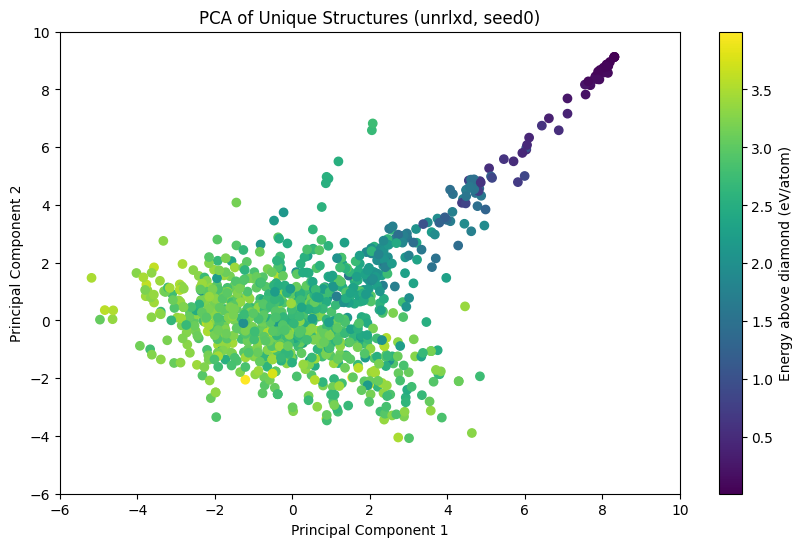

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=delta_en_per_atom, cmap="viridis")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Unique Structures ('+rlxd_string+', seed'+str(seed)+')')
plt.xlim(-6, 10)
plt.ylim(-6, 10)
# ## for rlxd pca
# plt.xlim(-5, 12)
# plt.ylim(-4, 7)
plt.colorbar(label='Energy above diamond (eV/atom)')

# plt.savefig('RAFFLE_pca_unique_structures_'+rlxd_string+'_seed'+str(seed)+'.png')

In [20]:
print(np.min(energies_per_atom))

-9.051900863647461
